# Configs

In [21]:
%load_ext autoreload
%autoreload 3
## other standard packages
import os
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from src_code.task_utils.config_parser import ConfigParser
configs_dict = {
    "data_configs": {
        "train_path": "datasets/utn_dataset_curated/part2/train",
        "val_path": "datasets/utn_dataset_curated/part2/val",
        "test_path": "datasets/utn_dataset_curated/part2/test",
        "preprocessing": {
            "mean": 0.5,  # for raw_image normalisation
            "std": 0.5,  # for raw_image normalisation
            "downscale_factor": 4,
        },
        "augmentation_related": {
            "place_holder": None,  # this is just a place holder, will be filled later
        },
    },
    "model_configs": {
        "epochs": 1,
        "batch_size": 32,
        "device": "cuda",  # either "cpu" or "cuda"
        "backbone": {
            "name": "VGG16",
            "num_stages": 6,
        },
        "loss": {
            "alpha": 1,  # loss = alpha*loc_loss + cls_loss
            "pos_box_threshold": 0.5,  # a default box is marked positive if it has (> pos_box_threshold) IoU score with any of the groundtruth boxes
            "hard_neg_pos": 3,  # num of negative boxes = hard_neg_pos * num_positive_boxes
        },
        "optim": {
            "name": "SGD",
            "lr": 0.001,
            "momentum": 0.9,
            "weight_decay": 0.0005,
        },
        "scheduler": {
            "name": "MultiStepLR",
            "milestones": [155, 195],
            "gamma": 0.1,
        },
    },
    "task_configs": {
        "img_height": 160,  # original image height
        "img_width": 640,  # original image width
        "debug": True,  # if True will display a lot of intermediate information for debugging purposes
        "log_expt": False,  # whether to log the experiment online or not
        "num_classes": 37,  # A-Z(26), 0-9(10), background(1)
        "min_cls_score": 0.01,  # if the cls score for a bounding box is less than this, it is considered as background
        "nms_iou_score": 0.1,  # if the iou between two bounding boxes is less than this, it is suppressed
    },
}
# hyperparameters
preprocessed_dir = "../datasets/utn_dataset_curated/part2/train/preprocessed"
labels_dir = "../datasets/utn_dataset_curated/part2/train/labels"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [22]:
import torch
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

In [23]:
config = ConfigParser(configs_dict).get_parser()
# this object can be used as follows:
print(f"{config.pos_box_threshold = }")

config = {'data_configs': {'train_path': 'datasets/utn_dataset_curated/part2/train', 'val_path': 'datasets/utn_dataset_curated/part2/val', 'test_path': 'datasets/utn_dataset_curated/part2/test', 'preprocessing': {'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'augmentation_related': {'place_holder': None}}, 'model_configs': {'epochs': 1, 'batch_size': 32, 'device': 'cuda', 'backbone': {'name': 'VGG16', 'num_stages': 6}, 'loss': {'alpha': 1, 'pos_box_threshold': 0.5, 'hard_neg_pos': 3}, 'optim': {'name': 'SGD', 'lr': 0.001, 'momentum': 0.9, 'weight_decay': 0.0005}, 'scheduler': {'name': 'MultiStepLR', 'milestones': [155, 195], 'gamma': 0.1}}, 'task_configs': {'img_height': 160, 'img_width': 640, 'debug': True, 'log_expt': False, 'num_classes': 37, 'min_cls_score': 0.01, 'nms_iou_score': 0.1}}
config.pos_box_threshold = 0.5


In [4]:
# note: change to relative import using a dot (.) in datautils line 4 & 5

# 0. Dataloader

In [24]:
print(sys.path)
from src_code.data_utils.dataset_utils import CaptchaDataset, get_dataloader
from src_code.data_utils.augmentation import Augmentations
# if the preprocessed dataset is not available, run create it using src_code/data_utils/preprocessing.py

# Create dataset
dataset = CaptchaDataset(preprocessed_dir, labels_dir, downscale_factor=4, augment=True)

# Load a sample
image, bboxes, labels = dataset[0]

print("Image Shape:", image.shape)
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


# Create DataLoader
dataloader = get_dataloader(dataset, batch_size=4, shuffle=True)

# Load a single batch
images, bboxes, labels = next(iter(dataloader))

# Print batch info
print(f"Batch Image Shape: {images.shape}")
print(f"Bounding Boxes (First Image): {bboxes[0]}")
print(f"Labels (First Image): {labels[0]}")


['../', '../', '../', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/lucaheller/Desktop/UTN_Captcha_Detector/.venv/lib/python3.11/site-packages', '/var/folders/ph/4ppm8f8950g15_ff9t0m53k80000gn/T/tmpvb0033_g']
Image Shape: torch.Size([1, 40, 160])
Bounding Boxes: tensor([[ 0.0358,  0.1204,  0.0500,  0.2146],
        [ 0.0827, -0.0028,  0.1153,  0.1276],
        [ 0.1045,  0.0661,  0.1364,  0.1926],
        [ 0.1936,  0.0773,  0.2194,  0.2038]])
Labels: tensor([21,  3, 24,  4])
Batch Image Shape: torch.Size([4, 1, 40, 160])
Bounding Boxes (First Image): tensor([[0.0239, 0.0571, 0.0543, 0.1802],
        [0.1161, 0.0160, 0.1511, 0.1538],
        [0.1989, 0.0420, 0.2237, 0.1413]])
Labels (First Image): tensor([21,  0, 33])


Image Shape: torch.Size([1, 40, 160])
Bounding Boxes: tensor([[ 0.0358,  0.1204,  0.0500,  0.2146],
        [ 0.0827, -0.0028,  0.1153,  0.1276],
        [ 0.1045,  0.0661,  0.1364,  0.1926],
        [ 0.1936,  0.0773,  0.2194,  0.2038]])
Labels: tensor([21,  3, 24,  4])
BBoxes for Visualization: tensor([[ 22,  19,  32,  34],
        [ 52,   0,  73,  20],
        [ 66,  10,  87,  30],
        [123,  12, 140,  32]], dtype=torch.int32)


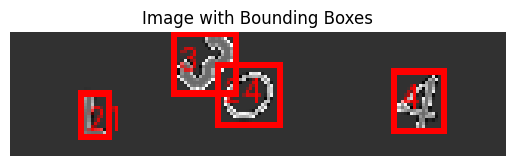

In [25]:

dataset = CaptchaDataset(preprocessed_dir, labels_dir, downscale_factor=4, augment=True)
# Load one sample for visualization
image, bboxes, labels = dataset[0]

print("Image Shape:", image.shape)
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


def plot_image_with_bboxes(image, bboxes, labels, title="Image with Bounding Boxes"):
    img_height, img_width = image.shape[1], image.shape[2] 
    
    # Scale normalized bboxes to absolute pixel values for visualization
    # TODO: --> * 4 used for non flipped images: works
    # Issue with flipped ones
    # How to test: set flip prob to one and you will see :)
    bboxes[:, [0, 2]] *= img_width * 4
    bboxes[:, [1, 3]] *= img_height * 4

    # Convert to integer values for plotting
    bboxes_abs = bboxes.to(torch.int)

    print("BBoxes for Visualization:", bboxes_abs)

    # Ensure labels are strings
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    labels = [str(l) for l in labels]

    # TODO: Image to RGB

    # Draw bboxes
    image_with_boxes = draw_bounding_boxes(image, bboxes_abs, labels=labels, colors="red", width=2)

    # image tensor to NumPy for visualization
    img = image_with_boxes.permute(1, 2, 0).numpy()
    
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


plot_image_with_bboxes(image, bboxes, labels)


# 1. Model

## 1.1 Model Architecture ...

## 1.2 Loss Function

In [19]:
from src_code.model_utils.loss import MultiBoxLoss
default_boxes = torch.Tensor([[0.5000, 0.1250, 0.5000, 0.1250],[0.5000, 0.3750, 0.5000, 0.1250],
        [0.5000, 0.6250, 0.5000, 0.1250],[0.5000, 0.8750, 0.5000, 0.1250],
        [0.5000, 0.1250, 0.5000, 0.0625],[0.5000, 0.3750, 0.5000, 0.0625],
        [0.5000, 0.6250, 0.5000, 0.0625],[0.5000, 0.8750, 0.5000, 0.0625]])
# (1, 8, 4)
locs_pred = torch.Tensor([[[0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.]]])

# (1, 8, 36)
cls_pred = torch.Tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])
boxes = torch.Tensor([[[ 61,  36, 139, 115], [297,  10, 386,  98], [509,  26, 572,  90]]])
labels = torch.Tensor([[21,  0, 33]])

# calculate loss
mbl = MultiBoxLoss(default_boxes, config)
loss, debug_info = mbl(locs_pred, cls_pred, boxes, labels)
expected_loss = 10.8635

In [20]:
loss

tensor(291.2195)

In [21]:
debug_info

{'overlap_gt_def_boxes': [tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]])],
 'db_for_each_obj': [tensor([0, 0, 0])],
 'db_indices_for_each_obj': [tensor([0, 0, 0])],
 'overlap_value_for_each_db': tensor([1., 0., 0., 0., 0., 0., 0., 0.]),
 'self.label_each_db': [tensor([33., 36., 36., 36., 36., 36., 36., 36.])],
 'match': [tensor([ True, False, False, False, False, False, False, False])],
 'gt_locs': [tensor([[  19.0000, 1071.0000,    5.8158,   12.6685],
          [  27.7500,  170.0000,    6.8686,   13.7364],
          [  27.7500,  150.0000,    6.8686,   13.7364],
          [  27.7500,  130.0000,    6.8686,   13.7364],
          [  27.7500,  380.0000,    6.8686,   17.2021],
          [  27.7500,  340.0000,    6.8686,   17.2021],
          [  27.7500,  300.0000,    6.8686,   17.2021],
          [  27.7500,  260.0000,    6.8686,   17.2021]]),
  tensor([[  19.0000, 1071.0000,    5.8158,   12.6685],
         

# 2. Training

# 3. Evaluation